# Credit Scoring Model (Task 2 — Rhombix Technologies ML Internship)

## Dataset
We use the **German Credit Data dataset** from Kaggle. This dataset contains information about loan applicants, including credit amount, duration, savings, checking accounts, employment, housing, and other attributes.

Since the dataset does not come with a target column for creditworthiness, we manually define a **Risk** column based on certain conditions (e.g., credit amount, duration, savings/checking accounts).

### 1. Import Libraries

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib


### 2. Load Dataset and Handle Missing Values

In [2]:

df = pd.read_csv("german_credit_data.csv")
df.replace("NA", pd.NA, inplace=True)


### 3. Create Target Column (Risk)

In [3]:

def calculate_risk(row):
    high_credit = row['Credit amount'] > 5000
    long_duration = row['Duration'] > 24
    low_savings = pd.isna(row['Saving accounts']) or row['Saving accounts'] in ['little', 'none']
    low_checking = pd.isna(row['Checking account']) or row['Checking account'] in ['little', 'none']

    if high_credit and long_duration and (low_savings or low_checking):
        return 2  # Bad risk
    else:
        return 1  # Good risk

df['Risk'] = df.apply(calculate_risk, axis=1)
df.to_csv("german_credit_with_risk.csv", index=False)


### 4. Inspect New Target Variable

In [4]:

print(df[['Credit amount', 'Duration', 'Saving accounts', 'Checking account', 'Risk']].head(10))
df.head()


   Credit amount  Duration Saving accounts Checking account  Risk
0           1169         6             NaN           little     1
1           5951        48          little         moderate     2
2           2096        12          little              NaN     1
3           7882        42          little           little     2
4           4870        24          little           little     1
5           9055        36             NaN              NaN     2
6           2835        24      quite rich              NaN     1
7           6948        36          little         moderate     2
8           3059        12            rich              NaN     1
9           5234        30          little         moderate     2


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,2,49,male,1,own,little,NaN,2096,12,education,1
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,2
4,4,53,male,2,free,little,little,4870,24,car,1


### 5. Dataset Class Distribution

/tmp/ipython-input-3769189303.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk', data=df, palette='coolwarm')


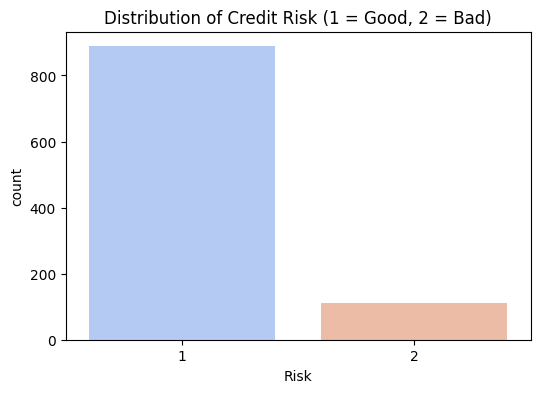

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Risk', data=df, palette='coolwarm')
plt.title("Distribution of Credit Risk (1 = Good, 2 = Bad)")
plt.show()


### 6. Correlation Heatmap (Numerical Features)

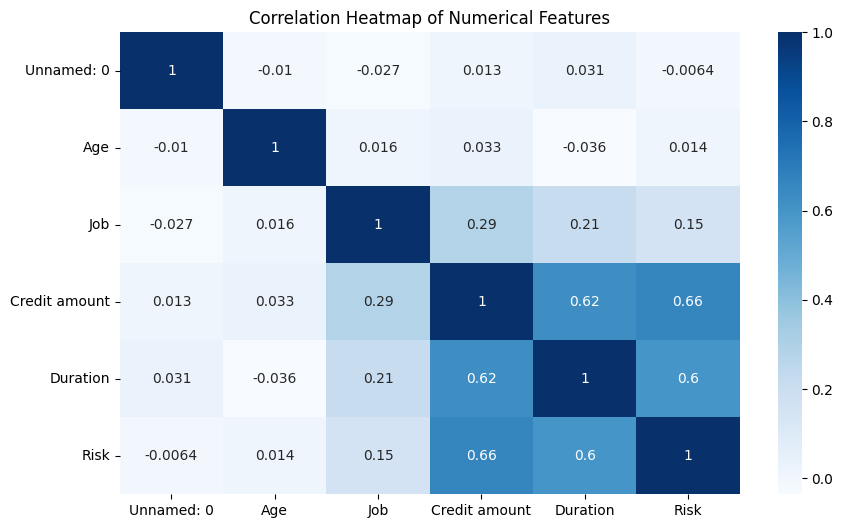

In [6]:

numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


### 7. Preprocessing Pipelines

In [7]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

X = df.drop('Risk', axis=1)
y = df['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


### 8. Model Training

In [8]:

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

### 9. Model Evaluation

In [9]:

from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       178
           2       1.00      1.00      1.00        22

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### 10. Confusion Matrix Visualization

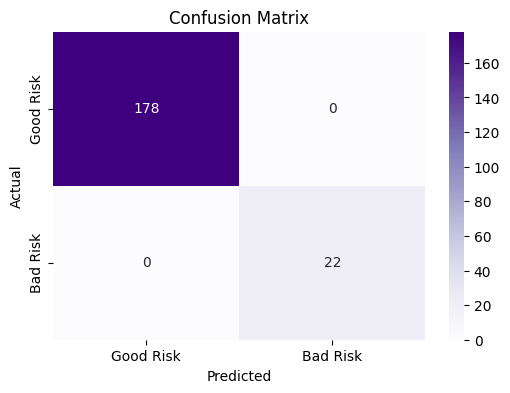

In [10]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples",
            xticklabels=["Good Risk", "Bad Risk"],
            yticklabels=["Good Risk", "Bad Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### 11. Feature Importance (Random Forest)

/tmp/ipython-input-1196892239.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


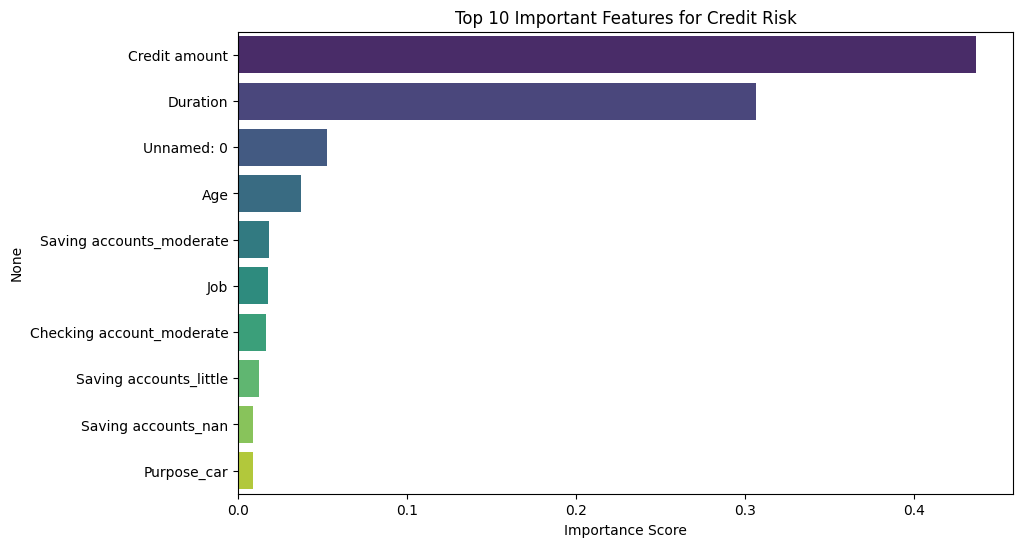

In [11]:

onehot_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = list(numerical_cols) + list(onehot_features)
importances = pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 10 Important Features for Credit Risk")
plt.xlabel("Importance Score")
plt.show()


## Summary
In this task, we:
1. Imported and cleaned the German Credit Data.
2. Created a Risk target column based on financial conditions.
3. Built preprocessing pipelines for numeric and categorical features.
4. Split the data into training and test sets.
5. Trained a Random Forest model within a pipeline.
6. Evaluated the model using classification metrics.
7. Visualized the class distribution, correlation heatmap, confusion matrix, and feature importance.

This notebook provides an end-to-end credit scoring solution for **Task 2 of Rhombix Technologies ML Internship**.